***
## <center>Prediction réseau convolutionnel 1D  </center>
***

In [1]:
# from MergeEtLireEtHisto import lirefichierh5
%matplotlib widget
from MergeEtLireEtHisto import lirefichierh5
from MergeEtLireEtHisto import histogrammesfichierfinal

import numpy as np
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import confusion_matrix
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import save_model
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


Charger les données

In [2]:
chemin='C:/Users/cayez/Documents/DONNEES SIMON/LPCNO/Appareils LPCNO/WAXS/stage M1/data/Ico_octa_deca_augmented_merged.h5'



Extraire les données sous forme de tableau numpy

In [3]:
data=lirefichierh5(chemin)

In [5]:
print(data[0].shape)

(5888, 10000)


In [6]:
# les données data sont un tableau de la forme:

iq_data = data[0]
particle_shape_data_string = data[1]
particle_size_data = data[2]
atom_type_data = data[3]

print ('iq_data' , iq_data.shape)
print ('particle_shape_data' , particle_shape_data_string.shape)
print ('particle_size_data' , particle_size_data.shape)
print ('atom_type_data' , atom_type_data.shape)

    
nbre_simu = iq_data.shape[0]
print(nbre_simu,' simulations')

iq_data (5888, 10000)
particle_shape_data (5888, 1)
particle_size_data (5888, 3)
atom_type_data (5888, 1)
5888  simulations


In [12]:
np.save('iq_data.npy',iq_data)
np.save('particle_shape_data_string.npy',particle_shape_data_string)
np.save('particle_size_data.npy',particle_size_data)
np.save('atom_type_data.npy',atom_type_data)

5888  simulations


In [2]:
iq_data = np.load('iq_data.npy')
particle_shape_data_string = np.load('particle_shape_data_string.npy')
particle_size_data = np.load('particle_size_data.npy')
atom_type_data = np.load('atom_type_data.npy')

nbre_simu = iq_data.shape[0]
print(nbre_simu,' simulations')


print ('iq_data' , iq_data.shape)
print ('particle_shape_data' , particle_shape_data_string.shape)
print ('particle_size_data' , particle_size_data.shape)
print ('atom_type_data' , atom_type_data.shape)

5888  simulations
iq_data (5888, 10000)
particle_shape_data (5888, 1)
particle_size_data (5888, 3)
atom_type_data (5888, 1)


In [3]:
# générer les valeurs de q comme dans la simu
qmin=0.001
qmax=20
qstep=0.002
q=np.arange(qmin, qmax, qstep)

#diminuer la gamme en q
# qmin_new = 0.001
# qmax_new = 2
qmin_new= 3
qmax_new= 16.6

indices = np.where((q >= qmin_new) & (q <= qmax_new ))
q_new = q[indices]
print('avant : ',q.shape)
print('apres : ',q_new.shape)

# Répéter le tableau pour obtenir les dimensions souhaitées
q_data = np.tile(q_new, (nbre_simu, 1))


avant :  (10000,)
apres :  (6800,)


In [4]:
print('avant : ', iq_data.shape)
iq_data = iq_data[:, indices[0]]

print('apres : ', iq_data.shape)


avant :  (5888, 10000)
apres :  (5888, 6800)


5888


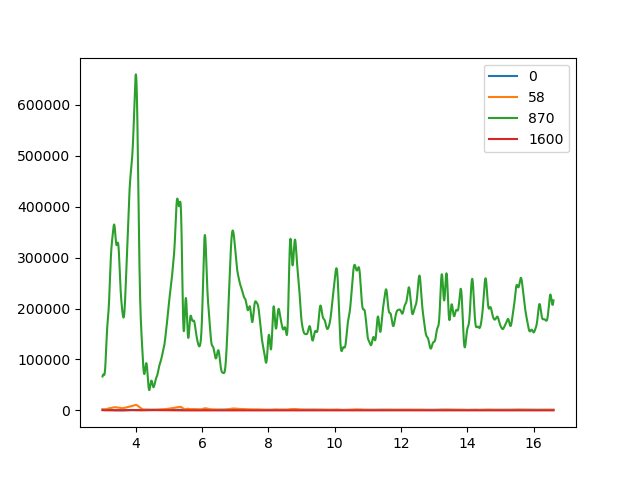

In [5]:
#previsualisation de quelques i de q
longueur_i = iq_data.shape[0] 
print(longueur_i)
fig,ax = plt.subplots()
# Créez une liste de titres correspondant à chaque courbe

for k in  (0,58,870,1600):
    ax.plot(q_data[k],iq_data[k],label = str(k))
    ax.legend()
plt.savefig('waxs.png')

Normalisation

In [7]:
nbre_simu = iq_data.shape[0]
print(nbre_simu)

#normalisation
# Calcul du maximum en ignorant les valeurs nulles

val_lmax = np.max(iq_data,axis=1,keepdims=True)

# val_lmax = np.max(iq_data,axis=1)
iq_data = iq_data / val_lmax



5888


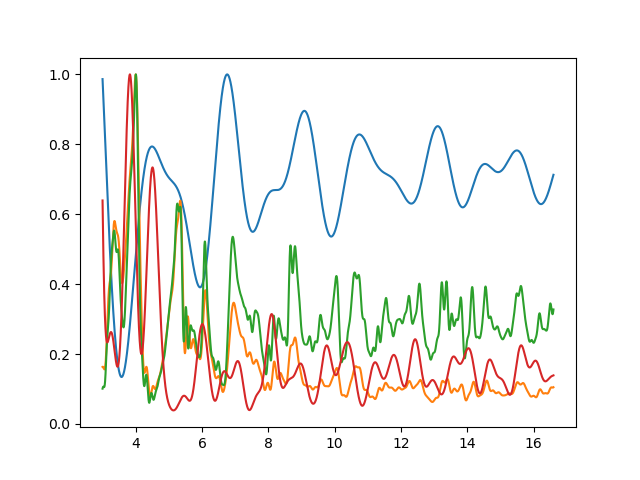

In [9]:
#previsualisation de quelques i de q
fig,ax = plt.subplots()
for k in (0,58,870,1600):
    ax.plot(q_data[k],iq_data[k])
plt.savefig('waxs_norm.png')

convertir les chaines en int pour classification

In [14]:
conversion_dict = {'Oct': 0, 'Dec': 1, 'Ico': 2}
particle_shape_data = np.array([[conversion_dict .get(item[0])] for item in particle_shape_data_string])


Verification du jeux de données

In [15]:
print(particle_shape_data[:,0])
print('--------------------')
print(particle_shape_data_string)
print(particle_shape_data_string[:,0])

[2 2 2 ... 2 2 2]
--------------------
[['Ico']
 ['Ico']
 ['Ico']
 ...
 ['Ico']
 ['Ico']
 ['Ico']]
['Ico' 'Ico' 'Ico' ... 'Ico' 'Ico' 'Ico']


In [16]:
occurrences_0 = np.count_nonzero(particle_shape_data[:, 0] == 0)
occurrences_1 = np.count_nonzero(particle_shape_data[:, 0] == 1)
occurrences_2 = np.count_nonzero(particle_shape_data[:, 0] == 2)

print("Nombre d'occurrences de 'Oct':", occurrences_0)
print("Nombre d'occurrences de 'Dec':", occurrences_1)
print("Nombre d'occurrences de 'Ico':", occurrences_2)

print('-------------------------')

occurrences_Oct = np.count_nonzero(particle_shape_data_string[:, 0] == 'Oct')
occurrences_Dec = np.count_nonzero(particle_shape_data_string[:, 0] == 'Dec')
occurrences_Ico = np.count_nonzero(particle_shape_data_string[:, 0] == 'Ico')

print("Nombre d'occurrences de 'Oct':", occurrences_Oct)
print("Nombre d'occurrences de 'Dec':", occurrences_Dec)
print("Nombre d'occurrences de 'Ico':", occurrences_Ico)




Nombre d'occurrences de 'Oct': 2208
Nombre d'occurrences de 'Dec': 1610
Nombre d'occurrences de 'Ico': 2070
-------------------------
Nombre d'occurrences de 'Oct': 2208
Nombre d'occurrences de 'Dec': 1610
Nombre d'occurrences de 'Ico': 2070


<class 'numpy.ndarray'>


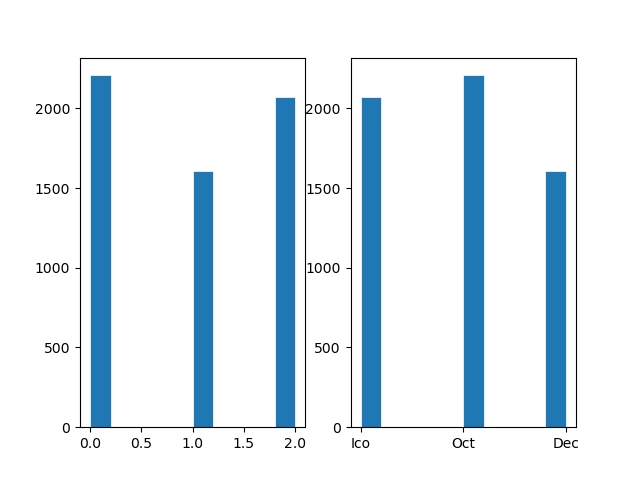

In [17]:
fig,ax = plt.subplots(1,2)
ax[0].hist(particle_shape_data[:,0], linewidth=0.5, edgecolor="white",label='taille')
ax[1].hist(particle_shape_data_string[:,0], linewidth=0.5, edgecolor="white",label='taille')
print(type(particle_shape_data[:,0]))

Diviser les données en ensembles d'entraînement et de test

In [18]:
X_train, X_test, y_train, y_test = train_test_split(iq_data, particle_shape_data, test_size=0.2, random_state=42)

(array([429.,   0.,   0.,   0.,   0., 309.,   0.,   0.,   0., 440.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

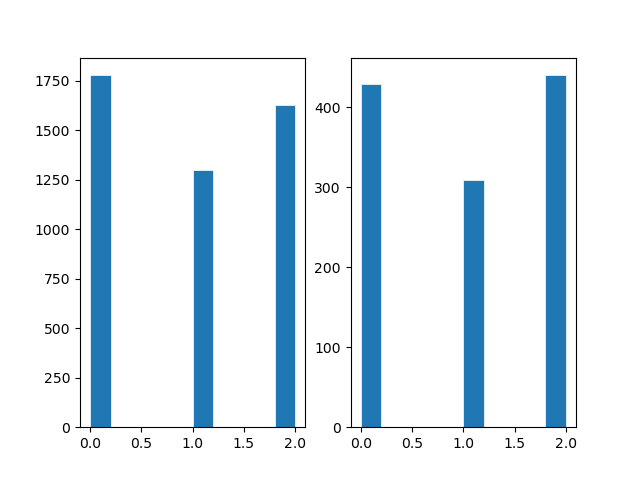

In [19]:
fig,ax = plt.subplots(1,2)
ax[0].hist(y_train[:,0], linewidth=0.5, edgecolor="white",label='train')
ax[1].hist(y_test[:,0], linewidth=0.5, edgecolor="white",label='test')

Convertir les étiquettes en encodage one-hot

In [20]:
y_train = to_categorical(y_train, num_classes=3)
y_test = to_categorical(y_test, num_classes=3)

Définir le model

In [21]:
model = Sequential()

# Couche de convolution 1D avec 32 filtres, une taille de noyau de 3 et une fonction d'activation ReLU
model.add(Conv1D(32, 3, activation='relu', input_shape=(iq_data.shape[1], 1)))

# Couche de pooling 1D avec une taille de pool de 2
model.add(MaxPooling1D(2))

# Aplatir les données
model.add(Flatten())

# Couche dense avec 64 neurones et une fonction d'activation ReLU
model.add(Dense(64, activation='relu'))

# Couche de sortie avec 1 neurone pour prédire la forme de la particule (binaire)
model.add(Dense(3, activation='softmax'))# 3 = nombre de classes



Remodelage des données pour compatibilité avec le model

In [22]:

print ('y_train.shape = ',y_train.shape)

print ('y_test.shape = ',y_test.shape)

# Remodelage des données X_train
X_train = X_train.reshape((X_train.shape[0], iq_data.shape[1], 1))
# Remodelage des données X_test
X_test = X_test.reshape((X_test.shape[0], iq_data.shape[1], 1))
print ('X_train.shape = ',X_train.shape)
print ('X_test.shape = ',X_test.shape)


y_train.shape =  (4710, 3)
y_test.shape =  (1178, 3)
X_train.shape =  (4710, 6800, 1)
X_test.shape =  (1178, 6800, 1)


(4710, 6800, 1)


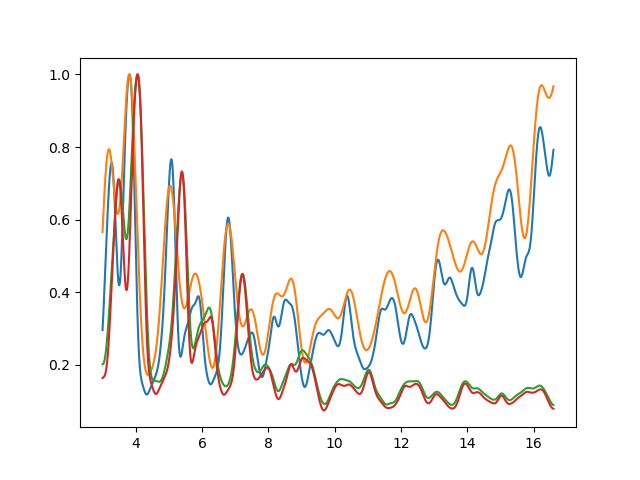

In [23]:
#nombre de plot aleatoires à tracer:
nbre_plots = 4
indices = np.random.choice(X_train.shape[0], nbre_plots , replace=False)
fig,ax = plt.subplots()
print(X_train.shape)
for index in indices:
    i = X_train[index, :, 0]
    ax.plot(q_data[index],i)

Normalisation

In [25]:
max_values = np.max(X_train, axis=1, keepdims=True)  # Calculer le maximum pour chaque exemple
X_train = X_train / max_values  # Diviser chaque exemple par son maximum

max_values = np.max(X_test, axis=1, keepdims=True)  # Calculer le maximum pour chaque exemple
X_test = X_test / max_values  # Diviser chaque exemple par son maximum

In [26]:
debut = time.time()
# Compiler le modèle avec une fonction de perte binaire_crossentropy et un optimiseur comme Adam
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Entraîner le modèle avec les données d'entraînement
history =model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test))
print('durée = ',time.time()-debut,'secondes')
model.save('conv1D6.h5')

Epoch 1/50
74/74 [==============================] - 7s 85ms/step - loss: 1.2690 - accuracy: 0.4195 - val_loss: 1.0121 - val_accuracy: 0.4830
Epoch 2/50
74/74 [==============================] - 7s 88ms/step - loss: 0.9845 - accuracy: 0.5168 - val_loss: 0.9353 - val_accuracy: 0.5688
Epoch 3/50
74/74 [==============================] - 7s 98ms/step - loss: 0.8890 - accuracy: 0.5747 - val_loss: 0.8200 - val_accuracy: 0.6248
Epoch 4/50
74/74 [==============================] - 7s 97ms/step - loss: 0.8165 - accuracy: 0.6236 - val_loss: 0.8709 - val_accuracy: 0.5348
Epoch 5/50
74/74 [==============================] - 7s 95ms/step - loss: 0.7617 - accuracy: 0.6439 - val_loss: 0.6928 - val_accuracy: 0.6732
Epoch 6/50
74/74 [==============================] - 7s 99ms/step - loss: 0.6549 - accuracy: 0.7197 - val_loss: 0.6489 - val_accuracy: 0.7029
Epoch 7/50
74/74 [==============================] - 7s 96ms/step - loss: 0.6308 - accuracy: 0.7212 - val_loss: 0.5827 - val_accuracy: 0.7445
Epoch 8/50
74

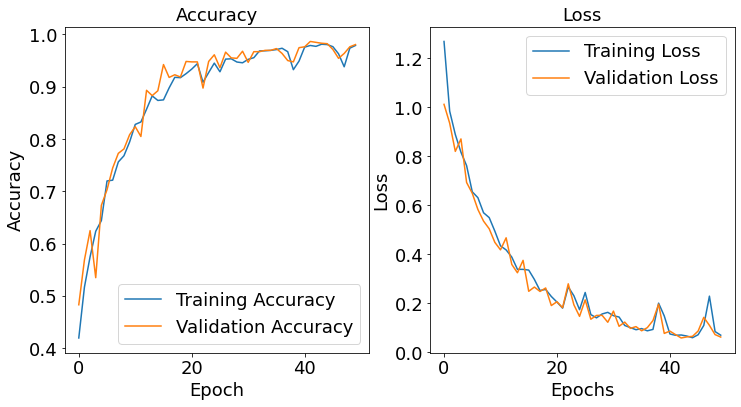

In [37]:
fig, ax = plt.subplots(1, 2,figsize=(12, 6))
plt.rc('font', size=18) 
# Courbes d'exactitude
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')

# Courbes de perte
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(['Training Loss', 'Validation Loss'], loc='upper right')


plt.savefig('training_shape2.png')

plt.show()


charger model

In [28]:
loaded_model = load_model('conv1D6.h5')

In [29]:
predictions = loaded_model.predict(X_test)
print(X_test.shape)

37/37 [==============================] - 1s 11ms/step
(1178, 6800, 1)


In [30]:
print(predictions)

[[1.21300836e-04 9.99689937e-01 1.88717691e-04]
 [4.91253473e-03 9.07641947e-02 9.04323339e-01]
 [2.08584936e-07 9.39792335e-06 9.99990284e-01]
 ...
 [2.86820505e-08 6.51482376e-04 9.99348462e-01]
 [9.99135792e-01 8.64253612e-04 6.51712571e-14]
 [9.34630334e-01 6.40132353e-02 1.35652872e-03]]


Convertir les prédictions en classes prédites (argmax)

In [31]:
y_pred_classes = np.argmax(predictions, axis=1)

Convertir les étiquettes réelles en classes réelles (argmax)

In [32]:
y_true_classes = np.argmax(y_test, axis=1)
print(y_test)

[[0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 ...
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]]


Calculer la matrice de confusion

In [33]:
cm = confusion_matrix(y_true_classes, y_pred_classes)

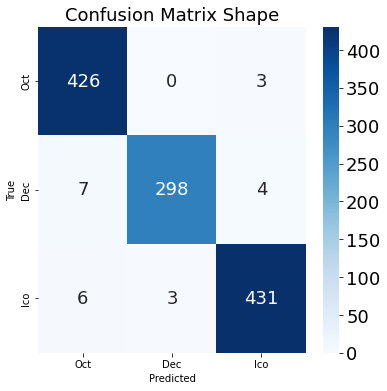

In [34]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(6, 6))
plt.rc('font', size=18) 
plt.rc('font', size=18) #controls default text size
plt.rc('axes', titlesize=18) #fontsize of the title
plt.rc('axes', labelsize=18) #fontsize of the x and y labels
plt.rc('xtick', labelsize=18) #fontsize of the x tick labels
plt.rc('ytick', labelsize=18) #fontsize of the y tick labels
plt.rc('legend', fontsize=18) #fontsize of the legend

# Tracer la matrice de confusion
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

classes = list(conversion_dict.keys())

# Configurer les axes et les étiquettes
tick_marks = np.arange(len(classes))
ax.set_xticks(tick_marks + 0.5)
ax.set_xticklabels(classes)
ax.set_yticks(tick_marks + 0.5)
ax.set_yticklabels(classes)

# Définir les étiquettes des axes x et y
ax.set_xlabel('Predicted')
ax.set_ylabel('True')

# Définir le titre
ax.set_title('Confusion Matrix Shape')

# Sauvegarder la figure
plt.savefig('confusion_matrix_shape2.png')

# Afficher la figure
plt.show()


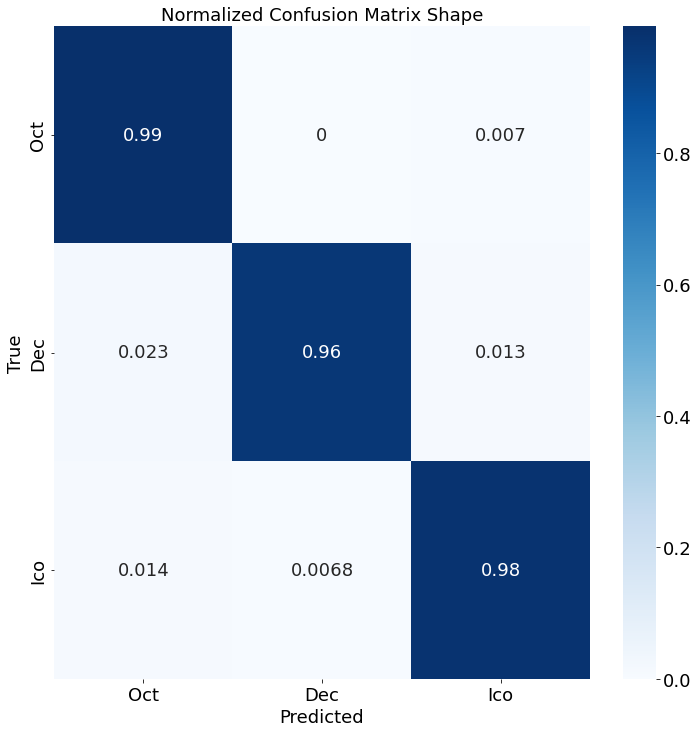

In [35]:
# Calculer la matrice de confusion normalisée
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Créer une nouvelle figure pour la matrice de confusion normalisée
fig, ax = plt.subplots(figsize=(12, 12))
plt.rc('font', size=18) 
# Tracer la matrice de confusion normalisée
sns.heatmap(cm_normalized, annot=True, cmap='Blues')

# Configurer les axes et les étiquettes
ax.set_xticks(tick_marks + 0.5)
ax.set_xticklabels(classes)
ax.set_yticks(tick_marks + 0.5)
ax.set_yticklabels(classes)

# Définir les étiquettes des axes x et y
ax.set_xlabel('Predicted')
ax.set_ylabel('True')

# Définir le titre
ax.set_title('Normalized Confusion Matrix Shape')

# Sauvegarder la figure
plt.savefig('normalized_confusion_matrix_shape2.png')

# Afficher la figure
plt.show()


In [36]:
# Convertir les prédictions en classes prédites (argmax)
y_pred_classes = np.argmax(predictions, axis=1)

# Convertir les étiquettes réelles en classes réelles (argmax)
y_true_classes = np.argmax(y_test, axis=1)

# Calculer l'exactitude
accuracy = accuracy_score(y_true_classes, y_pred_classes)
print('Accuracy = ',accuracy,'%')

Accuracy =  0.9804753820033956 %
